In [147]:
import numpy as np
import matplotlib.pyplot as plt

#CT Radon transform forward model and denoising functions
from skimage.transform import radon, resize, iradon
from skimage.data import shepp_logan_phantom
from skimage.restoration import denoise_tv_chambolle

#MNIST dataset
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Deep inverse imports
import deepinv as dinv
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot
from deepinv.models import DnCNN, DRUNet, UNet, AutoEncoder, epll, GSDRUNet, GSPnP
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP, RED

from deepinv.optim.optimizers import optim_builder


torch.manual_seed(42)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([transforms.ToTensor()])


def PSNR(original, img):
    max_value =  1
    mse = F.mse_loss(original, img.flatten())
    if mse == 0:
        return 100
    psnr = 20 * torch.log10(max_value / (torch.sqrt(mse)))
    return psnr



(-0.5, 27.5, 27.5, -0.5)

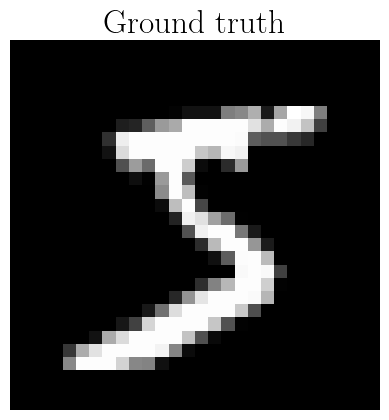

In [998]:
mnist = MNIST(root='./data', train=True, download=True, transform=transform)
digit, label = mnist[0]
imsize = (28,28)
digit = digit.reshape(-1)
plt.title("Ground truth")
plt.imshow(digit.view(imsize), cmap = "gray")
plt.axis('off')

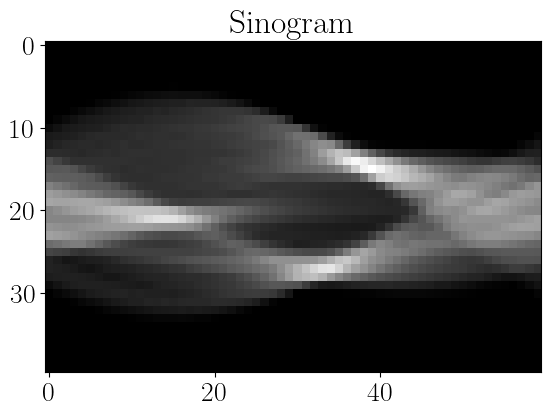

In [999]:
#Radon transform

def forward_operator_radon(n, angles):
    """
    Forward operator - Radon transform discretised version with matrix A^(m x n^2)
    n - number of pixels of input image
    m - number of angles for the Radon transform to be performed
    """
    circle = False
    theta = np.linspace(0., 180., angles, endpoint=False)
    size = radon(np.zeros((n, n)), theta=theta, circle=circle).shape
    M = size[0] * size[1]
    A = torch.zeros((M, n**2), dtype=torch.float32)
    
    for i in range(n**2):
        e = torch.zeros((n**2,), dtype=torch.float32)
        e[i] = 1
        e = e.view(n, n)
        
        # Convert e to numpy for radon
        sinogram = radon(e.numpy(), theta=theta, circle=circle)
        
        # Convert sinogram back to torch and assign to A
        A[:, i] = torch.from_numpy(sinogram.flatten())
    
    return A


n = 28
n_angles = 60


#ground truth

x = digit.reshape(-1)

A = forward_operator_radon(n, n_angles)

#y
y = np.reshape(A@x, (int(np.ceil(n*np.sqrt(2))), n_angles))
plt.title("Sinogram")
plt.imshow(y, cmap='gray')

In [426]:
A.shape

torch.Size([2400, 784])

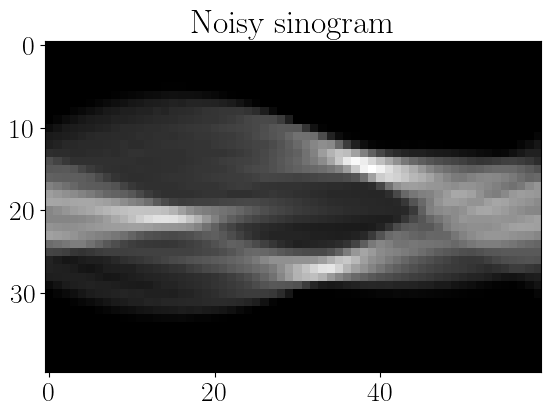

In [1119]:
# Add noise to the sinogram (Gaussian and Poisson)
def add_noise(sinogram, noise_type='gaussian', sigma=0.01):
    """
    Add different types of noise to a sinogram
    sinogram - original sinogram input
    noise_type - the type of noise to add ['gaussian', 'poisson']
    sigma - standard deviation for Gaussian noise input
    """

    if noise_type == 'gaussian':
        noise = torch.randn_like(sinogram) * sigma
        noisy_sinogram = sinogram + noise
    
    elif noise_type == 'poisson':
        noisy_sinogram = torch.poisson(sinogram)


    return noisy_sinogram


# FBP reconstruction in torch
def fbp(sinogram, angles):
    sinogram_np = sinogram.numpy()
    theta = np.linspace(0., 180., angles, endpoint=False)
    reconstructed_image = iradon(sinogram_np, theta=theta, circle=False)
    return torch.from_numpy(reconstructed_image)



# Add Gaussian and Poisson noise to the sinogram
sigma = 0.01
gauss_y = add_noise(y, noise_type='gaussian', sigma = sigma)
poisson_y = add_noise(y, noise_type='poisson')
gy = add_noise(y, noise_type='gaussian', sigma = 0.002)
plt.title("Noisy sinogram")
plt.imshow(gauss_y.numpy(), cmap='gray')




Text(0.5, 1.0, 'Noise-free FBP reconstruction')

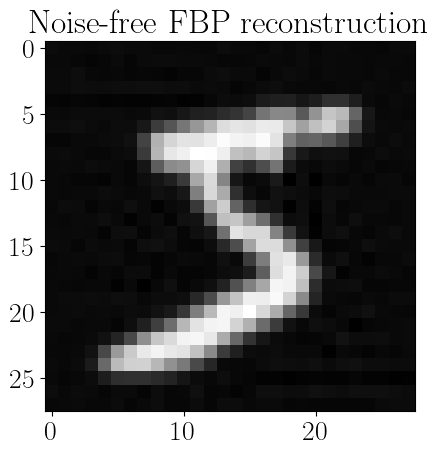

In [1120]:
#Noise free FBP

reconstruction_fbp = fbp(y, n_angles)
plt.imshow(reconstruction_fbp, cmap='gray')
plt.title('Noise-free FBP reconstruction')


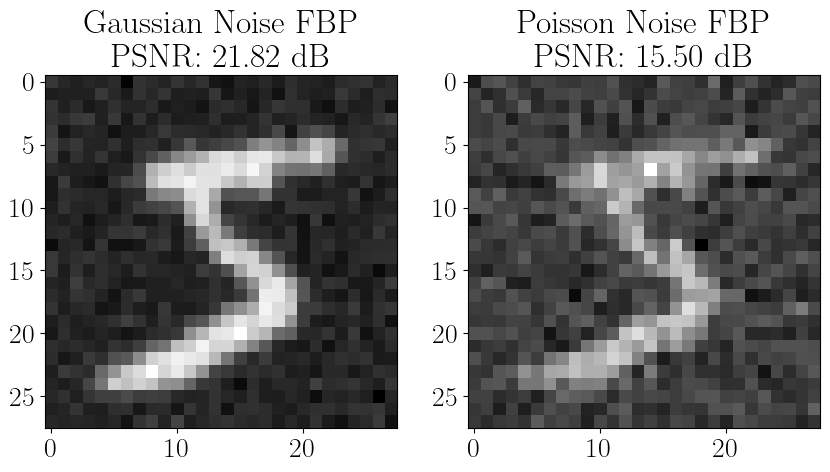

In [1245]:
#Noisy reconstruction
s = 0.05
gfbp = fbp(gauss_y, n_angles)
gf = fbp(gy, n_angles)
pfbp = fbp(poisson_y, n_angles)
gfbp =  gfbp.reshape(n, n) + torch.randn(n,n)*s
g_psnr = PSNR(x, gfbp)
p_psnr = PSNR(x, pfbp)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f"Gaussian Noise FBP \n PSNR: {g_psnr:.2f} dB")
plt.imshow(gfbp, cmap='gray')

plt.subplot(1, 2, 2)
plt.title(f"Poisson Noise FBP \n PSNR: {p_psnr:.2f} dB")
plt.imshow(pfbp, cmap='gray')

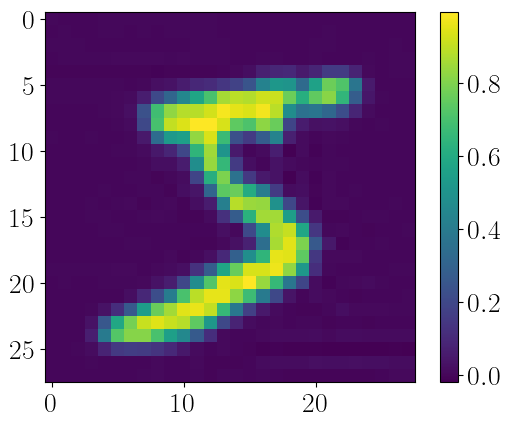

In [1122]:
w = gf.reshape(imsize)
w = w.unsqueeze(0).unsqueeze(0)
w = dncnn(w, sigma = s)
#w = gsdrunet(w, sigma = s)
w =  w.squeeze(0).squeeze(0).detach()

plt.imshow(w.reshape(imsize).numpy())
plt.colorbar()

In [197]:
# plotting functions

def comparison_plot(norm_res, method, ytitle='PSNR', color='k', title = 'PSNR'):
    K = len(norm_res)

    plt.plot(range(1, len(norm_res) + 1),norm_res, color=color, label=method)
    k = np.arange(K)
    plt.title(title)
    plt.ylabel(ytitle)
    plt.xlabel('number of iterations: k')
    plt.legend()
    plt.grid(True)

def display_images(image_list, image_titles, ground_truth):
    titles = []
    for img, title in zip(image_list, image_titles):
        
        #cur_min = np.round(np.amin(img), 1)
        #cur_max = np.round(np.amax(img), 1)
        #bounds = '{} to {}'.format(str(cur_min), str(cur_max))
        psnr = PSNR(ground_truth, img)
        titles.append(title + f' PSNR: {psnr:.2f} dB \n')
        

        #nrmse = pnpm.nrmse(img, ground_truth)
        #titles.append(title + ' [NRMSE: ' + str(nrmse) + ']')

    for img, title in zip(image_list, titles):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 5))
        

        ax.imshow(img, cmap='gray')
        #pnpm.display_image(img, fig=fig, ax=ax, cmap='gray')

        plt.suptitle(title)
        plt.tight_layout()
        fig.show()

# Optimisation algorithms (PGD and ADMM) for reconstruction (priors)

In [198]:
from tqdm import tqdm
from bm3d import bm3d
from utils.torch_denoise_tv_chambolle import *

In [768]:
#Deep denoisers
channels = 1
# DnCNN Zhang 2017 denoiser
dncnn = DnCNN(
    in_channels=channels,
    out_channels=channels,
    pretrained="download",  
    device="cpu",
)

# Zhang 2021 denoiser
drunet = DRUNet(
    in_channels= channels,
    out_channels= channels,
    pretrained="download",
    device="cpu",
)


In [784]:
#GS-DRUNet class with GSPnP and the GS-DRUNet function
import torch
import torch.nn as nn
from deepinv.models.utils import get_weights_url



class StudentGrad(nn.Module):
    def __init__(self, denoiser):
        super().__init__()
        self.model = denoiser

    def forward(self, x, sigma):
        return self.model(x, sigma)


class GSPnP(nn.Module):
    r"""
    Gradient Step module to use a denoiser architecture as a Gradient Step Denoiser.
    See https://arxiv.org/pdf/2110.03220.pdf.
    Code from https://github.com/samuro95/GSPnP.

    :param nn.Module denoiser: Denoiser model.
    :param float alpha: Relaxation parameter
    """

    def __init__(self, denoiser, alpha=1.0, train=False):
        super().__init__()
        self.student_grad = StudentGrad(denoiser)
        self.alpha = alpha
        self.train = train

    def potential(self, x, sigma, *args, **kwargs):
        N = self.student_grad(x, sigma)
        return (
            0.5
            * self.alpha
            * torch.norm((x - N).view(x.shape[0], -1), p=2, dim=-1) ** 2
        )

    def potential_grad(self, x, sigma, *args, **kwargs):
        r"""
        Calculate :math:`\nabla g` the gradient of the regularizer :math:`g` at input :math:`x`.

        :param torch.Tensor x: Input image
        :param float sigma: Denoiser level :math:`\sigma` (std)
        """
        with torch.enable_grad():
            x = x.float()
            x = x.requires_grad_()
            N = self.student_grad(x, sigma)
            JN = torch.autograd.grad(
                N, x, grad_outputs=x - N, create_graph=True, only_inputs=True
            )[0]
        Dg = x - N - JN
        return self.alpha * Dg

    def forward(self, x, sigma):
        r"""
        Denoising with Gradient Step Denoiser

        :param torch.Tensor x: Input image
        :param float sigma: Denoiser level (std)
        """
        Dg = self.potential_grad(x, sigma)
        x_hat = x - Dg
        return x_hat


def GSDRUNet(
    alpha=1.0,
    in_channels=3,
    out_channels=3,
    nb=2,
    nc=[64, 128, 256, 512],
    act_mode="E",
    pretrained=None,
    train=False,
    device=torch.device("cpu"),
):
    """
    Gradient Step Denoiser with DRUNet architecture

    :param float alpha: Relaxation parameter
    :param int in_channels: Number of input channels
    :param int out_channels: Number of output channels
    :param int nb: Number of blocks in the DRUNet
    :param list nc: Number of channels in the DRUNet
    :param str act_mode: activation mode, "R" for ReLU, "L" for LeakyReLU "E" for ELU and "S" for Softplus.
    :param str downsample_mode: Downsampling mode, "avgpool" for average pooling, "maxpool" for max pooling, and
        "strideconv" for convolution with stride 2.
    :param str upsample_mode: Upsampling mode, "convtranspose" for convolution transpose, "pixelsuffle" for pixel
        shuffling, and "upconv" for nearest neighbour upsampling with additional convolution.
    :param bool download: use a pretrained network. If ``pretrained=None``, the weights will be initialized at random
        using Pytorch's default initialization. If ``pretrained='download'``, the weights will be downloaded from an
        online repository (only available for the default architecture).
        Finally, ``pretrained`` can also be set as a path to the user's own pretrained weights.
        See :ref:`pretrained-weights <pretrained-weights>` for more details.
    :param bool train: training or testing mode.
    :param str device: gpu or cpu.

    """
    from deepinv.models.drunet import DRUNet

    denoiser = DRUNet(
        in_channels=in_channels,
        out_channels=out_channels,
        nb=nb,
        nc=nc,
        act_mode=act_mode,
        pretrained=None,
        train=train,
        device=device,
    )
    GSmodel = GSPnP(denoiser, alpha=alpha, train=train)
    if pretrained:
        if pretrained == "download":
            if in_channels == 3 and out_channels == 3:
                url = get_weights_url(
                    model_name="gradientstep", file_name="GSDRUNet_torch.ckpt"
                )
                ckpt = torch.hub.load_state_dict_from_url(
                    url,
                    map_location=lambda storage, loc: storage,
                    file_name="GSDRUNet_torch.ckpt",
                )
            elif in_channels == 1 and out_channels == 1:
                url = get_weights_url(
                    model_name="gradientstep", file_name="GSDRUNet_grayscale_torch.ckpt"
                )
                ckpt = torch.hub.load_state_dict_from_url(
                    url,
                    map_location=lambda storage, loc: storage,
                    file_name="GSDRUNet_grayscale_torch.ckpt",
                )
        else:
            ckpt = torch.load(pretrained, map_location=lambda storage, loc: storage)

        if "state_dict" in ckpt:
            ckpt = ckpt["state_dict"]

        GSmodel.load_state_dict(ckpt, strict=False)
    return GSmodel




In [785]:
# GS-DRUNet denoiser
gsdrunet = GSDRUNet(
    in_channels= 1,
    out_channels= 1,
    pretrained="download",
    device="cpu",
)


#gsdrunet.eval()
H = A.T @ A

In [786]:
def power_method(A, num_iterations=1000, tol=1e-6):
    # Initialize a random vector b
    n = A.size(0)
    b = torch.randn(n, 1)

    # Perform the power method iterations
    for _ in range(num_iterations):
        # Multiply A with b
        Ab = torch.mm(A, b)

        # Estimate the eigenvalue
        eigenvalue_estimate = torch.dot(b.squeeze(), Ab.squeeze()) / torch.dot(b.squeeze(), b.squeeze())

        # Normalize b
        b = Ab / torch.norm(Ab)

        # Check for convergence
        if torch.norm(Ab - b * eigenvalue_estimate) < tol:
            break

    return eigenvalue_estimate.item()

# Example usage:
ev = power_method(H)
print(f"Largest eigenvalue estimate: {ev}")

Largest eigenvalue estimate: 1620.8892822265625


In [1116]:
torch.norm(A) ** 2 

tensor(32110.8281)

In [1250]:
#PnP-PGD
#ISTA
def soft_thresh(x, l):
    return torch.sign(x) * F.relu(torch.abs(x) - l)


       
def apply_denoiser(x, l, sigma = sigma,  method = 'tv'):
        """
        Denoiser options to replace the proximal step
        """
        if method == 'tv':
            return denoise_tv_chambolle_torch(x, weight = l)
        elif method == 'bm3d':
            print()
            #x = torch.to_numpy(x)
            #print(x.shape)
            x = bm3d(x.reshape(imsize), sigma_psd = sigma*1e+1).flatten()
            return torch.from_numpy(x).float()
        elif method == 'proximal':
            return soft_thresh(x, l)
        elif method == 'DnCNN':
            #print('DnCNN')
            x = x.unsqueeze(0).unsqueeze(0)
            x = dncnn(x, sigma = sigma)
            return x.squeeze(0).squeeze(0)
        elif method == 'DRUNet':
            x = x.reshape(imsize)
            x = x.unsqueeze(0).unsqueeze(0)
            #print("x shape before:", x.shape)
            x = drunet(x, sigma = sigma)
            return x.squeeze(0).squeeze(0).flatten().detach()
        elif method == "GS-DRUNet":
            x = x.reshape(imsize)
            #print("x shape before:", x.shape)
            x = x.unsqueeze(0).unsqueeze(0)
            #print("x shape after:", x.shape)
            x = gsdrunet(x, sigma = sigma)
            x =  x.squeeze(0).squeeze(0)
            return x.flatten().detach()

def pnp_pgd(A, b, x_truth, method = None, reg_l = 1e-4, iters = 50, tol = 1e-3, sigma = sigma, L = ev):
    """
    PnP iterative shrinkage thrseholding algorithm (PnP-ISTA)
    """

    x = torch.zeros_like(x_truth, requires_grad=False)
    #x = fbp(b, n_angles).flatten()
    psnrs = []
    iterates_pairs = []
    differences = []
    increments = []
    #L = torch.norm(A) ** 2  # Lipschitz constant
    t = 1 / L # Initial stepsize
    b = b.flatten()

    #f = lambda x: 0.5 * torch.norm(A @ x - b) ** 2
    #grad_f =lambda x: A.T @ (A @ x - b)

    for i in tqdm(range(iters), desc = str(method) + '-PnP PGD iterations'):
        #gradient descent step
        current_grad = A.T @ (A @ x - b)
        #print("current gradient:", current_grad)
        x_new = x - (t * current_grad)
           
        
        #backtracking line search (Armijo condition)
        """
        while True:
            x_new = x - (t * current_grad)
            if (torch.norm(A @ (x_new - x)) ** 2) <=  t*(current_grad.T @ current_grad):
                break
            t *= 0.5
        """

        #denoising step (proximal step)
        denoised_x = apply_denoiser(x_new, reg_l, method = method, sigma = sigma)
        
        #x = soft_thresh(x_descent, l / L)

        #inverted and denoised iterates stored
        iterates_pairs.append((x_new, denoised_x))
        #difference between "noisy and denoised iterates"
        diff = x_new - denoised_x
        differences.append(diff)
        #print("MSE for new iterate:", torch.norm(x_truth - denoised_x)**2)
        incr = torch.norm(x - denoised_x)
        increments.append(incr)
        #new estimate
        x = denoised_x
        psnr = PSNR(x_truth, x)
        psnrs.append(psnr)
        if torch.norm(current_grad) <= tol:  # Termination criterion
            print('Iteration {}: gradient norm {:.4e} is less than tolerance {}\n'.format(i, torch.norm(current_grad), tol))
            break

    print(f"Final PSNR: {psnr:.2f} dB")

    return x, psnrs, differences, iterates_pairs, increments


def pnp_fista(A, b, x_truth, method = None, reg_l = 1e-5, iters = 50, tol = 1e-3, sigma = sigma):
    """
    PnP FISTA (accelerated PGD)
    """
    #ground = 0.5 * np.linalg.norm(A.dot(x_g) - b) ** 2 + l * np.linalg.norm(x_g, 1)
    x = torch.zeros_like(x_truth, requires_grad=False)
    #x = fbp(b, n_angles).flatten()
    psnrs = []
    iterates_pairs = []
    differences = []
    increments = []
    L = ev
    #L = torch.norm(A) ** 2  # Lipschitz constant
    #t = 1 / L # Initial stepsize
    b = b.flatten()
    

    #Initialisation of parameters (step size and initial guesses)
    t = 1
    z = x.clone()
    
    for i in tqdm(range(iters), desc = 'PnP FISTA iterations'):
        grad_g = A.T @ (A @ x - b)
        xold = x.clone()
        z = z + A.T @(b - A @ z) / L
        zold = z.clone()
        x = apply_denoiser(z, reg_l, method= method, sigma = sigma)
        t0 = t
        t = (1 + torch.sqrt(torch.tensor(1 + 4 * t ** 2))) / 2.
        z = x + ((t0 - 1) / t) * (x - xold)
        
        incr = torch.norm(x - xold)
        increments.append(incr)

        #inverted and denoised iterates stored
        iterates_pairs.append((zold, x))
        #difference between "noisy and denoised iterates"
        diff = zold - x 
        differences.append(diff)

        #print("MSE for new iterate:", torch.norm(x_truth - denoised_x)**2)

        psnr = PSNR(x_truth, x).detach()
        psnrs.append(psnr)
        if torch.norm(grad_g) <= tol:  # Termination criterion
            print('Iteration {}: gradient norm {:.4e} is less than tolerance {}\n'.format(i, torch.norm(grad_g), tol))
            break

    print(f"PnP-{method} Final PSNR: {psnr:.2f} dB")
    return x, psnrs, differences, iterates_pairs, increments



In [ ]:
lamb = 1e-4
best = 0
for lamb in [1e-5, 1e-4, 1e-3, 1, 1e+1]:
    tv, r1, d1, tvpairs, tincr = pnp_fista(A, gauss_y, x, method = 'tv', reg_l = lamb, iters = 500)
    if r1[-1] >= best:
        best = r1[-1]
        b_lamb = lamb

print("Best lambda:", b_lamb)
#plt.imshow(prox.reshape(imsize), cmap = 'gray')

# PnP-PGD results

In [1105]:
#tv
x_tv, tvr, tvdiff, tvpairs, tvincr = pnp_pgd(A, gauss_y, x, method = 'tv', reg_l = 1e-4, iters = 200)
#plt.imshow(x_tv.reshape(imsize), cmap = 'gray')

tv-PnP PGD iterations: 100%|██████████| 200/200 [00:00<00:00, 471.00it/s]

Final PSNR: 33.06 dB


In [1251]:
x_tv, tvr, tvdiff, tvpairs, tvincr = pnp_fista(A, gauss_y, x, 'tv', reg_l = 1e-4, iters = 200)
#plt.imshow(x_tv.reshape(imsize), cmap = 'gray')

PnP FISTA iterations:   0%|          | 0/200 [00:00<?, ?it/s]C:\Users\as5057\AppData\Local\Temp\ipykernel_3012\1891610402.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = (1 + torch.sqrt(torch.tensor(1 + 4 * t ** 2))) / 2.
PnP FISTA iterations: 100%|██████████| 200/200 [00:00<00:00, 205.25it/s]

PnP-tv Final PSNR: 45.60 dB


In [1252]:
#bm3d
#x_bm3d, bm3dr, bm3diff, bm3dpairs, bm3dincr = pnp_fista(A, gauss_y, x, method = 'bm3d', reg_l = 1e-5, iters = 200)
x_bm3d, bm3dr, bm3diff, bm3dpairs, bm3dincr = pnp_pgd(A, gauss_y, x, method = 'bm3d', reg_l = 1e-5, iters = 200)

bm3d-PnP PGD iterations:  92%|█████████▏| 183/200 [08:10<00:46,  2.73s/it]

bm3d-PnP PGD iterations:  92%|█████████▏| 184/200 [08:12<00:41,  2.60s/it]

bm3d-PnP PGD iterations:  92%|█████████▎| 185/200 [08:14<00:34,  2.33s/it]

bm3d-PnP PGD iterations:  93%|█████████▎| 186/200 [08:15<00:29,  2.14s/it]

bm3d-PnP PGD iterations:  94%|█████████▎| 187/200 [08:17<00:28,  2.18s/it]

bm3d-PnP PGD iterations:  94%|█████████▍| 188/200 [08:20<00:27,  2.32s/it]

bm3d-PnP PGD iterations:  94%|█████████▍| 189/200 [08:23<00:28,  2.55s/it]

bm3d-PnP PGD iterations:  95%|█████████▌| 190/200 [08:26<00:24,  2.48s/it]

bm3d-PnP PGD iterations:  96%|█████████▌| 191/200 [08:28<00:23,  2.61s/it]

bm3d-PnP PGD iterations:  96%|█████████▌| 192/200 [08:32<00:22,  2.84s/it]

bm3d-PnP PGD iterations:  96%|█████████▋| 193/200 [08:35<00:19,  2.80s/it]

bm3d-PnP PGD iterations:  97%|█████████▋| 194/200 [08:37<00:15,  2.65s/it]

bm3d-PnP PGD iterations:  98%|█████████▊| 195/200 [08:39<00:12,  2.60s/it]

bm3d-PnP PGD iterations:  98%|█████████▊| 196/200 [08:42<00:10,  2.51s/it]

bm3d-PnP PGD iterations:  98%|█████████▊| 197/200 [08:44<00:07,  2.57s/it]

bm3d-PnP PGD iterations:  99%|█████████▉| 198/200 [08:46<00:04,  2.43s/it]

bm3d-PnP PGD iterations: 100%|█████████▉| 199/200 [08:49<00:02,  2.40s/it]

bm3d-PnP PGD iterations: 100%|██████████| 200/200 [08:51<00:00,  2.66s/it]

Final PSNR: 17.31 dB


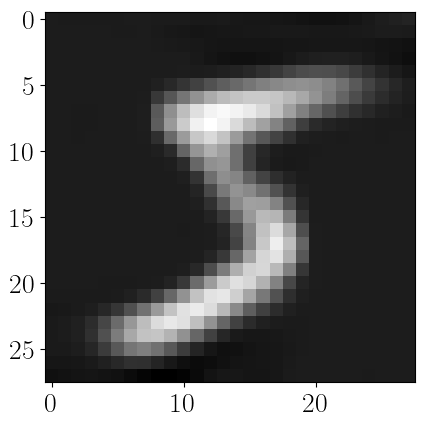

In [1253]:
plt.imshow(x_bm3d.reshape(imsize), cmap='gray')

In [1107]:
#deep denoisers (DnCNN and DRUNet)
x_dncnn, cnnr, cnndiff, cnnpairs, cnnincr = pnp_pgd(A, gauss_y, x, method = 'DnCNN', iters = 200)
#plt.imshow(x_dncnn.reshape(n,n), cmap='gray')

DnCNN-PnP PGD iterations: 100%|██████████| 200/200 [00:02<00:00, 87.13it/s]

Final PSNR: 28.54 dB


In [1111]:
a, b, c, d, e = pnp_pgd(A, gauss_y, x, method = 'tv', reg_l = 1e-4, iters = 125)
x_dncnn = a

tv-PnP PGD iterations: 100%|██████████| 125/125 [00:00<00:00, 681.28it/s]

Final PSNR: 30.81 dB


In [957]:
p = 0
bl = 0
for l in [850, 870,  900, 950]:
    x_drunet, drur, drudiff, drupairs, druincr = pnp_pgd(A, gauss_y, x, method = 'DnCNN', iters = 200, L= l)
    if drur[-1] >= p:
        p = drur[-1]
        bl = l 

print("Best PSNR:", p, " with best stepsize:", bl)

DnCNN-PnP PGD iterations: 100%|██████████| 200/200 [00:02<00:00, 93.84it/s] 


Final PSNR: 30.66 dB


DnCNN-PnP PGD iterations: 100%|██████████| 200/200 [00:02<00:00, 91.53it/s]


Final PSNR: 30.59 dB


DnCNN-PnP PGD iterations: 100%|██████████| 200/200 [00:02<00:00, 81.94it/s]


Final PSNR: 30.48 dB


DnCNN-PnP PGD iterations: 100%|██████████| 200/200 [00:02<00:00, 83.81it/s]

Final PSNR: 30.30 dB
Best PSNR: tensor(30.6624)  with best stepsize: 850


In [1254]:
#deep denoisers
it = 200
#x_dncnn, cnnr, cnndiff, cnnpairs, cnnincr = pnp_admm(A, gauss_y, x, method = 'DnCNN', niter = it)
#x_drunet, drur, drudiff, drupairs, druincr = pnp_admm(A, gauss_y, x, method = 'DRUNet', niter = it)
x_dncnn, cnnr, cnndiff, cnnpairs, cnnincr = pnp_pgd(A, gauss_y, x, method = 'DnCNN', iters = it, reg_l= 100,  L = 850)
x_drunet, drur, drudiff, drupairs, druincr = pnp_pgd(A, gauss_y, x, method = 'DRUNet', iters = it, L = 750)
x_gsdrunet, gsdrur, gsdrudiff, gsdrupairs, gsdruincr = pnp_pgd(A, gauss_y, x, method = 'GS-DRUNet', iters = it, L = 800)

DnCNN-PnP PGD iterations:   0%|          | 0/200 [00:00<?, ?it/s]

DnCNN-PnP PGD iterations: 100%|██████████| 200/200 [00:02<00:00, 81.93it/s]


Final PSNR: 30.97 dB


DRUNet-PnP PGD iterations: 100%|██████████| 200/200 [00:10<00:00, 19.55it/s]


Final PSNR: -45.66 dB


GS-DRUNet-PnP PGD iterations: 100%|██████████| 200/200 [00:22<00:00,  8.88it/s]

Final PSNR: 29.61 dB


In [868]:
x_dncnn, cnnr, cnndiff, cnnpairs, cnnincr = pnp_pgd(A, gauss_y, x, method = 'DnCNN', iters = it)
x_drunet, drur, drudiff, drupairs, druincr = pnp_pgd(A, gauss_y, x, method = 'DRUNet', iters = it)
x_gsdrunet, gsdrur, gsdrudiff, gsdrupairs, gsdruincr = pnp_pgd(A, gauss_y, x, method = 'GS-DRUNet', iters = it)

DnCNN-PnP PGD iterations: 100%|██████████| 200/200 [00:02<00:00, 85.81it/s]


Final PSNR: 28.37 dB


DRUNet-PnP PGD iterations: 100%|██████████| 200/200 [00:15<00:00, 13.04it/s]


Final PSNR: 19.07 dB


GS-DRUNet-PnP PGD iterations: 100%|██████████| 200/200 [00:22<00:00,  8.80it/s]

Final PSNR: 20.61 dB


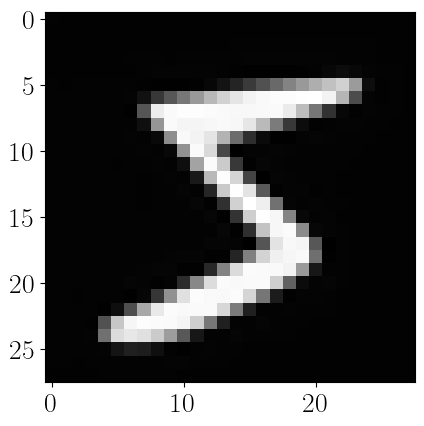

In [1108]:
plt.imshow(x_drunet.reshape(imsize), cmap='gray')

In [931]:
x_gsdrunet, gsdrur, gsdrudiff, gsdrupairs, gsdruincr = pnp_pgd(A, gauss_y, x, method = 'GS-DRUNet', iters = 500)

GS-DRUNet-PnP PGD iterations: 100%|██████████| 500/500 [00:55<00:00,  8.94it/s]

Final PSNR: 20.74 dB


In [950]:
xvals =np.arange(1, 201)
yvals = 1/xvals

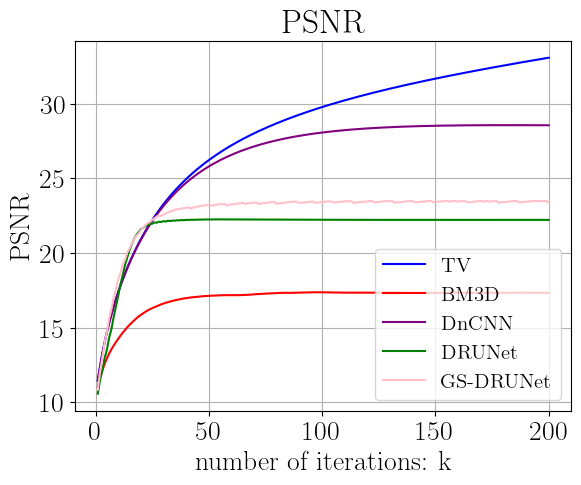

In [1109]:
#comparison_plot(proxr,'Proximal', color='orange')
comparison_plot(tvr, 'TV', color='blue')
comparison_plot(bm3dr, 'BM3D', color='red')
comparison_plot(cnnr, 'DnCNN', color='purple')
comparison_plot(drur, 'DRUNet', color='green')
comparison_plot(gsdrur, 'GS-DRUNet', color='pink')


# Noise distribution between iterates for the denoisers $(D(x^{(k)}) - x^{(k)})$

In [310]:
import pylab as plot
params = {'legend.fontsize': 15,
          'legend.handlelength': 2,
          "font.size": 20,
          "text.usetex": True,
          "font.family": "Computer Modern Roman",
          #"label.fontsize": 18
          }
plot.rcParams.update(params)

In [752]:
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kstest, cramervonmises, norm, ecdf
def pdf_plot(noise_diff, iterates_pairs, iteration, title):
    """
    Plotting the differences between inverted and denoised iterates of x^(k)
    """
    fontsize = 20
    fig1, axs = plt.subplots(1, 3, figsize=(12, 4))
    noised_x = iterates_pairs[iteration][0].reshape(imsize)
    denoised_x = iterates_pairs[iteration][1].reshape(imsize)
    fig1.suptitle(title + str(iteration + 1), fontsize = fontsize)
    axs[0].imshow(noised_x, cmap = 'gray')
    axs[1].imshow(denoised_x, cmap = 'gray')
    axs[2].imshow(noise_diff.reshape(imsize), cmap = 'gray')

    axs[0].set_title('Inverted iterate', fontsize = fontsize)
    axs[1].set_title('Denoised iterate', fontsize = fontsize)
    axs[2].set_title('$x^{(k)} - D_{\\sigma}(x^{(k)})$', fontsize = fontsize)
    plt.tight_layout()
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    plt.show()

    #Normalising the pixel values
    noise_diff = (noise_diff - torch.min(noise_diff))/(torch.max(noise_diff) - torch.min(noise_diff))
    #noise_diff = (noise_diff - torch.mean(noise_diff))/(torch.std(noise_diff))
    noise_diff_np = noise_diff.numpy().flatten()
    iterate = title + str(iteration+1)

    #Reference gaussian pdf with same mean and standard deviation
    xrange = np.linspace(0, 1, 1000)
    mu, std = np.mean(noise_diff_np), np.std(noise_diff_np)
    gaussian_pdf = norm.pdf(xrange, loc=mu, scale=std)
    

    #Compute kernel density estimate (kde for pdf of noise distribution)
    fig2 = plt.figure(figsize=(8,6))
    kde = sm.nonparametric.KDEUnivariate(noise_diff) 
    kde.fit()

    peak_index = np.argmax(kde.density)
    peak_value = kde.support[peak_index]
    # Set the range around the peak
    x_range = kde.support[(kde.support >= peak_value - 2) & (kde.support <= peak_value + 2)]
    
    #fig = plt.figure(layout="constrained", figsize=(12, 5))
    plt.hist(noise_diff, density = True, bins = 80, alpha = 0.5, color="#D58817", label = 'Histogram frequency')
    plt.plot(kde.support, kde.density, color="#5AB4DC", label = 'Kernel density estimate PDF (KDE)')
    plt.plot(xrange, gaussian_pdf, label='Gaussian PDF', color='red', linestyle='--')
    #sns.kdeplot(noise_diff.numpy(), fill = True, color='g')

    plt.xlim([0.001, 1.001])
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    plt.title(iterate + " \n PDF of pixel intensities for $x^{(k)} - D_{\\sigma}(x^{(k)})$", fontsize = fontsize)
    plt.grid(True)
    plt.legend()
    
    plt.show()
    
    
    D, p_value = kstest(noise_diff_np, 'norm', args=(mu, std))
    print(f'KS Test: D-statistic={D:.4f}, p-value={p_value:.4f}')
    
    if p_value > 0.05:
        print("The residual noise appears to follow a Gaussian distribution (accept H0)")
    else:
        print("The residual noise does not appear to follow a Gaussian distribution (reject H0)")
        
    


In [757]:
r = gauss_y - y
noise_diff_np = r.numpy().flatten()
ncdf = norm.cdf(np.linspace(-3, 3, len(noise_diff_np)))

normalized_gaussian = norm.cdf(np.linspace(-3, 3, len(noise_diff_np))) 
#ks test
mu, std = np.mean(noise_diff_np), np.std(noise_diff_np)
D, p_value = kstest(noise_diff_np, 'norm', args=(mu, std))
print(f'KS Test: D-statistic={D:.4f}, p-value={p_value:.4f}')


KS Test: D-statistic=0.0141, p-value=0.7246


In [735]:
standard_normal_cdf = lambda x: norm.cdf(x, loc=mu, scale=std)  # Centered at 0.5 with a small spread

# Perform the KS test
ks_statistic, p_value = kstest(normalised, standard_normal_cdf)

print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

KS Statistic: 0.6369088060127602
P-value: 0.0


In [ ]:
for i in range(9, 50):
    w = atvdiff[i]
    noise_diff = (w - torch.min(w))/(torch.max(w) - torch.min(w))
    noise_diff_np = noise_diff.numpy().flatten()
    normalized_gaussian = norm.cdf(np.linspace(-3, 3, len(noise_diff_np))) 
    #ks test
    mu, std = np.mean(noise_diff_np), np.std(noise_diff_np)
    D, p_value = kstest(noise_diff_np, 'norm', args=(mu, std))
    print(f'{i:}th iteration, KS Test: D-statistic={D:.4f}, p-value={p_value:.4f}')

    result = cramervonmises(noise_diff_np, lambda x: np.interp(x, np.linspace(0, 1, len(normalized_gaussian)), normalized_gaussian))
    print("Cramér-von Mises Statistic:", result.statistic)
    print("P-value:", result.pvalue)


In [ ]:

result = cramervonmises(noise_diff_np, norm.cdf(noise_diff_np, loc=mu, scale=std))
D, p_value = kstest(noise_diff_np, 'norm', args=(mu, std))
cdf = norm.cdf(noise_diff_np, loc=mu, scale=std)

if p_value > 0.05:
    print("The residual noise difference appears to follow a Gaussian distribution (accept H0)")
else:
    print("The residual noise difference does not appear to follow a Gaussian distribution (reject H0)")

In [ ]:
shift = 0
iterates = [0, 5, 15, 199] 
for i in [49, 99, 149, 199]:
    #pdf_plot(proxdiff[i+shift], proxpairs, iteration = i+shift, title = "Prox iterate: $k=$ ")
    pdf_plot(atvdiff[i+shift], atvpairs, iteration = i+shift, title = "TV iterate: $k=$ ")
    #pdf_plot(acnndiff[i+shift], adncnnpairs, iteration = i+shift, title = "DnCNN iterate: $k=$ ")
    #pdf_plot(adrudiff[i+shift], adrupairs, iteration = i+shift, title = "DRUNet iterate: $k=$ ")
    #pdf_plot(gsdrudiff[i+shift], agsdrupairs, iteration = i+shift, title = "GS-DRUNet iterate: $k=$ ")
    #pdf_plot(abm3diff[i], abm3dpairs, iteration = i, title = "BM3D iterate: $k=$ ")

In [ ]:
shift = 0
iterates = [0, 199] 
for i in iterates:
    #pdf_plot(proxdiff[i+shift], proxpairs, iteration = i+shift, title = "Prox iterate: $k=$")
    pdf_plot(tvdiff[i+shift], tvpairs, iteration = i+shift, title = "TV iterate: $k=$")
    #pdf_plot(cnndiff[i+shift], cnnpairs, iteration = i+shift, title = "DnCNN iterate: $k=$")
    #pdf_plot(drudiff[i+shift], drupairs, iteration = i+shift, title = "DRUNet iterate: $k=$")
    #pdf_plot(gsdrudiff[i+shift], gsdrupairs, iteration = i+shift, title = "GS-DRUNet iterate: $k=$")
    pdf_plot(bm3diff[i], bm3dpairs, iteration = i, title = "BM3D iterate: $k=$")

In [715]:
D, p_value = kstest(np.random.normal(0,1, 100), 'norm', args=(0, 1))
print(f'KS Test: D-statistic={D:.4f}, p-value={p_value:.4f}')

KS Test: D-statistic=0.1095, p-value=0.1684


In [ ]:
pdf_plot(gfbp.flatten() - x, [[gfbp.flatten(), x]], iteration = 0, title = "Orignal vs noisy sinogram")

<>:18: SyntaxWarning: invalid escape sequence '\|'
<>:36: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\|'
<>:36: SyntaxWarning: invalid escape sequence '\s'
C:\Users\as5057\AppData\Local\Temp\ipykernel_3012\2412466885.py:18: SyntaxWarning: invalid escape sequence '\|'
  ax2.set_ylabel('$\\|x^{(k+1)} - x^{(k)}\|_2$')
C:\Users\as5057\AppData\Local\Temp\ipykernel_3012\2412466885.py:36: SyntaxWarning: invalid escape sequence '\s'
  ax2.semilogy(iterations, 12/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)
C:\Users\as5057\AppData\Local\Temp\ipykernel_3012\2412466885.py:36: RuntimeWarning: divide by zero encountered in divide
  ax2.semilogy(iterations, 12/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)


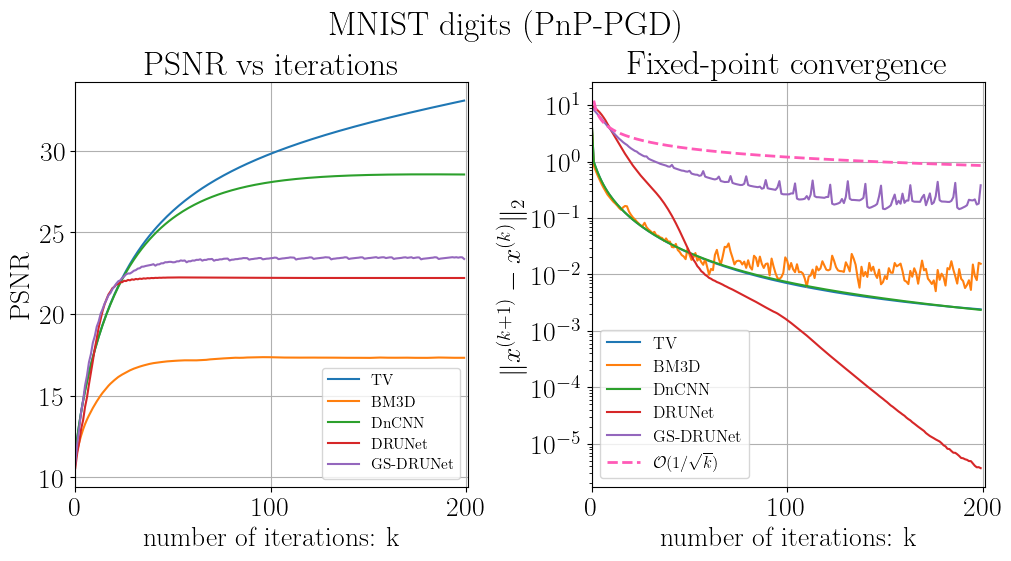

In [1162]:
#Main plotting and reconstruction functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
fig.suptitle('MNIST digits (PnP-PGD)')
ax1.set_title('PSNR vs iterations')
ax2.set_title('Fixed-point convergence')
def plot_psnrs_differences(psnrs, diffs, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """

    #fig.suptitle(method)
    ax1.plot(range(0, len(psnrs)), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)

    ax2.semilogy(range(0, len(diffs)),diffs, label = method)
    ax2.set_ylabel('$\\|x^{(k+1)} - x^{(k)}\|_2$')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)
    ax1.set_xlim([0, 201])
    ax2.set_xlim([0, 201])
    return psnrs[-1]


#p1 = plot_psnrs_differences(proxr, proxincr, 'Prox')
t1 = plot_psnrs_differences(tvr, tvincr, 'TV')
b1 = plot_psnrs_differences(bm3dr, bm3dincr, 'BM3D')
d1 = plot_psnrs_differences(cnnr, cnnincr, 'DnCNN')
dr1 = plot_psnrs_differences(drur, druincr, 'DRUNet')
gs1 = plot_psnrs_differences(gsdrur, gsdruincr, 'GS-DRUNet')

iterations = np.arange(200)

#ax2.semilogy(iterations, 80/iterations, label = '$\\mathcal{O}(1/k)$', linestyle = '--', color = '#13A49F', linewidth = 2)
ax2.semilogy(iterations, 12/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)

psnrs_list = [PSNR(x, gfbp), t1, b1, d1, dr1, gs1]

ax1.legend(fontsize = 11, loc = 'lower right')
ax2.legend(fontsize = 12)

plt.savefig('plots/PnPPGDGraphs.png', dpi = 300)


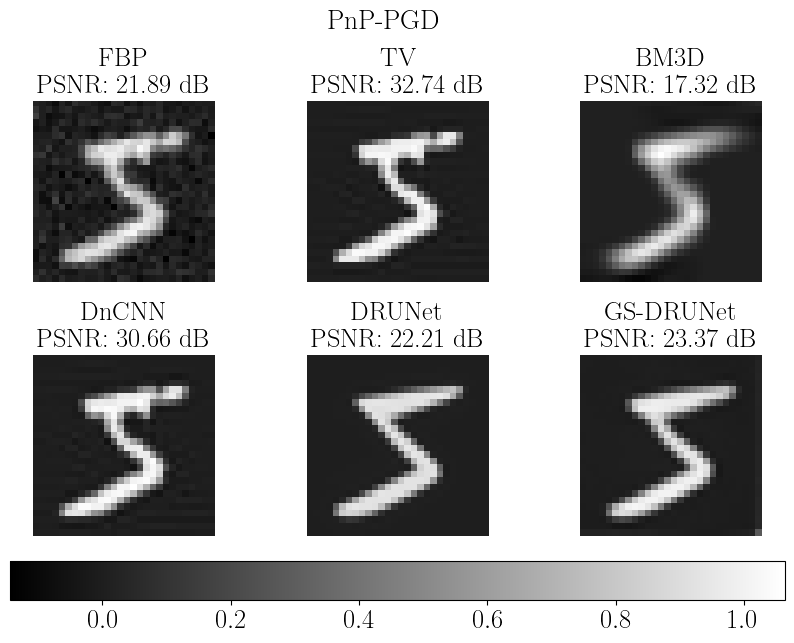

In [1112]:
def plotting_estimates1(fbp, x1, x2, x3, x4, x5, psnrs_list, title):
    size = 19
    fig, axs = plt.subplots(2, 3, figsize=(10, 6.5))
    fig.subplots_adjust(hspace=0.4)
    fig.suptitle(title, size = 20, y = 1.02)

    vmin = min(fbp.min(), x1.min(), x2.min(), x3.min(), x4.min(), x5.min())
    vmax = max(fbp.max(), x1.max(), x2.max(), x3.max(), x4.max(), x5.max())

    # Plotting the images
    im0 = axs[0, 0].imshow(fbp, cmap='gray', vmin=vmin, vmax=vmax)
    axs[0, 0].set_title(f"FBP \n PSNR: {psnrs_list[0]:.2f} dB", fontsize=size)
    axs[0, 1].imshow(x1, cmap='gray', vmin=vmin, vmax=vmax)
    axs[0, 1].set_title(f'TV \n PSNR: {psnrs_list[1]:.2f} dB', fontsize=size)
    axs[0, 2].imshow(x2, cmap='gray', vmin=vmin, vmax=vmax)
    axs[0, 2].set_title(f'BM3D \n PSNR: {psnrs_list[2]:.2f} dB', fontsize=size)
    axs[1, 0].imshow(x3, cmap='gray', vmin=vmin, vmax=vmax)
    axs[1, 0].set_title(f'DnCNN \n PSNR: {psnrs_list[3]:.2f} dB', fontsize=size)
    axs[1, 1].imshow(x4, cmap='gray', vmin=vmin, vmax=vmax)
    axs[1, 1].set_title(f'DRUNet \n PSNR: {psnrs_list[4]:.2f} dB', fontsize=size)
    axs[1, 2].imshow(x5, cmap='gray', vmin=vmin, vmax=vmax)
    axs[1, 2].set_title(f'GS-DRUNet \n PSNR: {psnrs_list[5]:.2f} dB', fontsize=size)

    # Adding a color bar for the whole figure
    cbar = fig.colorbar(im0, ax=axs, orientation='horizontal', fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=size)
    for i in range(2):
        for j in range(3):
            axs[i, j].axis('off')

imsize = (n, n)

plotting_estimates1(gfbp.reshape(imsize), x_tv.reshape(imsize), x_bm3d.reshape(imsize), x_dncnn.reshape(imsize), x_drunet.reshape(imsize), x_gsdrunet.reshape(imsize), psnrs_list, title = "PnP-PGD")

In [1068]:
#PnP-ADMM (torch version)
def pnp_admm(A, b, x_ground_truth, method = None, niter = 50, beta = 1e+1, lamb = 1e-3, sigma = sigma):
    n = int(torch.sqrt(torch.tensor(A.shape[1])))
    
    # Define the 3 variables for use
    x = torch.zeros_like(x_ground_truth)
    u = torch.zeros_like(x_ground_truth)
    v = torch.zeros_like(x_ground_truth)
    psnrs = []
    iterates_pairs = []
    diffs = []
    increments =[]
    inv_beta = 1/beta

    # PnP ADMM iteration performed on the 3 variables
    for i in tqdm(range(niter), desc= str(method) + '-PnP ADMM iterations'):
        x_k = x
        #print("b shape:", b.shape)
        #measurement = b.reshape((int(torch.ceil(n * torch.sqrt(torch.tensor(2)))), n))
        correction = (A @ (inv_beta * (u - v)))
        #print("correction shape:", correction.shape)
        #print("b shape:", b.shape)
        sinogram = b + correction.reshape(40, 60)
        #print("b shape:", b.shape)
        x = fbp(sinogram, n_angles).flatten().float()
        #print("x fbp shape:", x.shape)

        # Reshaping u and v for the denoiser (2D shape)
        #u = u.reshape((n, n))
        #v = v.reshape((n, n))
        u = apply_denoiser(x + v, lamb, method = method, sigma = sigma).float()
        #print("u shape:", u.shape)
        

        v = (v + x - u).float()

        # Flattening u and v for the next iteration (2D to 1D)
        #u = u.flatten()
        #v = v.flatten()


        increment = torch.norm(x - x_k)
        diff = x - u

        #inverted and denoised iterates stored
        iterates_pairs.append((x, u))
        
        #print("MSE for new iterate:", torch.norm(x_truth - denoised_x)**2)
        
        increments.append(increment)
        #difference between "noisy and denoised iterates"
        diffs.append(diff)

        current_psnr = PSNR(x_ground_truth, x)
        psnrs.append(current_psnr)

    print(f"Final PSNR: {current_psnr:.2f} dB")

    return x, psnrs, diffs, iterates_pairs, increments
    



tv-PnP ADMM iterations: 100%|██████████| 30/30 [00:00<00:00, 199.09it/s]


Final PSNR: 24.30 dB


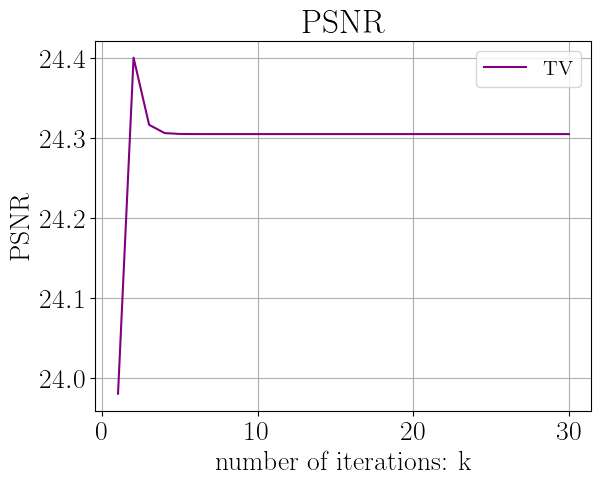

In [1123]:
atv, atvp, atvd, atvpairs, atvincr = pnp_admm(A, gauss_y, x, 'tv', niter = 30, lamb = 1e-3, beta = 10)
comparison_plot(atvp, 'TV', color='purple')

In [1124]:
aprox, aproxpnsr, aproxdiff, aproxpairs, aproxincr = pnp_admm(A, gauss_y, x, 'proximal', niter = 50, lamb = 1e-4)

proximal-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 317.09it/s]

Final PSNR: 24.31 dB


In [762]:
lambs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
betas = [1e+1, 1e+2]
best = 0
b_lamb, b_beta = 0, 0
for l in lambs:
    for beta in betas:
        atv, atvp, atvd, atvpairs, atvincr = pnp_admm(A, gauss_y, x, 'tv', niter = 50, lamb = l)
        if atvp[-1] > best:
            best = atvp[-1]
            b_lamb, b_beta = lamb, beta

print("Best beta:", b_beta, "\n Best lambda:", b_lamb)
beta = 1e+1
lamb = 1


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 161.37it/s]


Final PSNR: 22.45 dB


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 227.78it/s]


Final PSNR: 22.45 dB


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 249.58it/s]


Final PSNR: 22.45 dB


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 248.44it/s]


Final PSNR: 22.45 dB


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 196.80it/s]


Final PSNR: 22.45 dB


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 207.38it/s]


Final PSNR: 22.45 dB


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 144.38it/s]


Final PSNR: 22.47 dB


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 174.13it/s]


Final PSNR: 22.47 dB


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 98.12it/s] 


Final PSNR: 22.65 dB


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 99.77it/s] 

Final PSNR: 22.65 dB
Best beta: 10.0 
 Best lambda: 10.0


In [1139]:
iters = 50
admm_gsdru, agsdrunetpsnr, agsdrudiff, agsdrupairs, agsdruincr = pnp_admm(A, gauss_y, x, 'GS-DRUNet', niter = 5, beta = 1e+2)

GS-DRUNet-PnP ADMM iterations: 100%|██████████| 5/5 [00:00<00:00,  6.02it/s]

Final PSNR: 24.07 dB


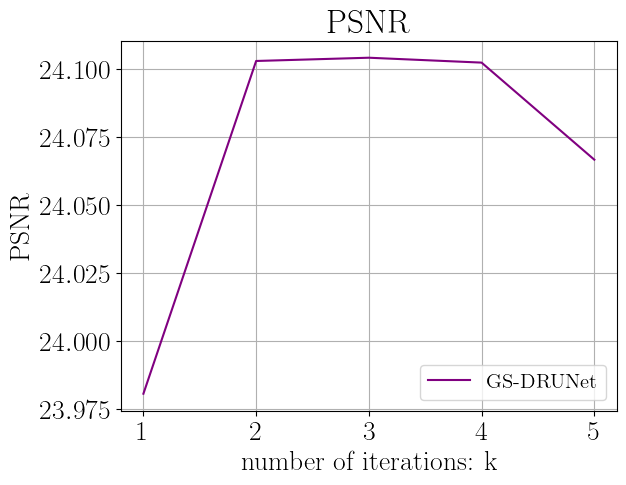

In [1255]:
comparison_plot(agsdrunetpsnr, 'GS-DRUNet', color='purple')
#comparison_plot(aproxpnsr, 'proximal', color='blue')

In [437]:
iters = 200
admm_gsdru, agsdrunetpsnr, agsdrudiff, agsdrupairs, agsdruincr = pnp_admm(A, gauss_y, x, 'GS-DRUNet', niter = iters)

GS-DRUNet-PnP ADMM iterations: 100%|██████████| 200/200 [00:19<00:00, 10.16it/s]

Final PSNR: nan dB


In [887]:
admm_bm3d, abm3dpsnr, abm3diff, abm3dpairs, abm3dincr = pnp_admm(A, gauss_y, x, 'bm3d', niter = 200, beta = 10)


bm3d-PnP ADMM iterations:  96%|█████████▋| 193/200 [03:36<00:15,  2.20s/it]

bm3d-PnP ADMM iterations:  97%|█████████▋| 194/200 [03:37<00:11,  1.87s/it]

bm3d-PnP ADMM iterations:  98%|█████████▊| 195/200 [03:40<00:11,  2.24s/it]

bm3d-PnP ADMM iterations:  98%|█████████▊| 196/200 [03:41<00:07,  1.97s/it]

bm3d-PnP ADMM iterations:  98%|█████████▊| 197/200 [03:44<00:06,  2.09s/it]

bm3d-PnP ADMM iterations:  99%|█████████▉| 198/200 [03:45<00:03,  1.85s/it]

bm3d-PnP ADMM iterations: 100%|█████████▉| 199/200 [03:49<00:02,  2.35s/it]

bm3d-PnP ADMM iterations: 100%|██████████| 200/200 [03:50<00:00,  1.15s/it]

Final PSNR: 24.25 dB


In [1040]:
admm_tv, atvpsnr, atvdiff, atvpairs, atvincr = pnp_admm(A, gauss_y, x, 'tv', niter = iters, lamb= 1e-1, beta = 10)

tv-PnP ADMM iterations: 100%|██████████| 200/200 [00:04<00:00, 41.01it/s]

Final PSNR: 24.18 dB


In [1177]:
iters = 50
#admm_prox, aproxpsnr, aproxdiff, aproxpairs, aproxincr = pnp_admm(A, gauss_y, x, 'proximal', niter = iters, beta = 10, lamb = 1)
#admm_bm3d, abm3dpsnr, abm3diff, abm3dpairs = pnp_admm(A, gauss_y, x, 'bm3d', niter = iters)
admm_tv, atvpsnr, atvdiff, atvpairs, atvincr = pnp_admm(A, gauss_y, x, 'tv', niter = iters, lamb= 1e-3, beta = 10)
admm_dncnn, adncnnpsnr, acnndiff, adncnnpairs, adncnnincr  = pnp_admm(A, gauss_y, x, 'DnCNN', niter = iters, beta = 100)


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 106.65it/s]


Final PSNR: 24.30 dB


DnCNN-PnP ADMM iterations: 100%|██████████| 50/50 [00:01<00:00, 40.55it/s]

Final PSNR: 24.11 dB


In [1065]:
admm_dru, adrunetpsnr, adrudiff, adrupairs, adruincr = pnp_admm(A, gauss_y, x, 'DRUNet', niter = iters, beta = 50)

DRUNet-PnP ADMM iterations: 100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


Final PSNR: 24.19 dB


In [1206]:
admm_gsdru, agspsnr, agsdrudiff, agsdrupairs, agsdruincr = pnp_admm(A, gauss_y, x, 'GS-DRUNet', niter = 2, beta = 1e+1)

GS-DRUNet-PnP ADMM iterations: 100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

Final PSNR: 24.38 dB


In [1207]:
gslist = []
for i in agspsnr:
    gslist.append(i)

In [1208]:
for i in range(48):
    gslist.append(24.38)

In [1239]:
agsincr = []
total = 1
for i in cnnincr:
    agsincr.append(i*0.01)
    total += 1
    if total == 51:
        break

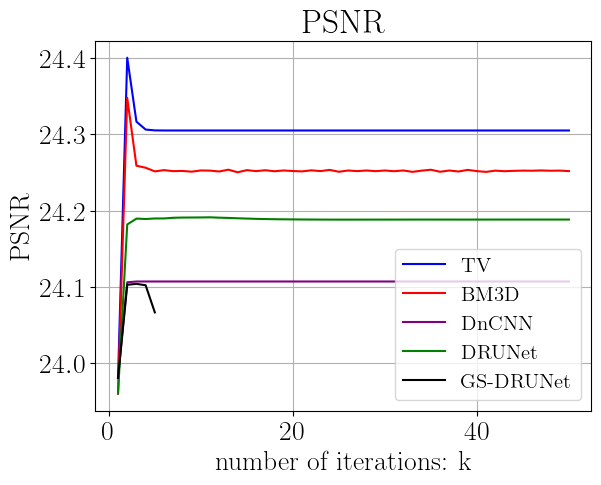

In [1184]:
#comparison_plot(aproxpsnr,'Proximal', color='orange')
comparison_plot(atvpsnr, 'TV', color='blue')
comparison_plot(abm3dpsnr[:50], 'BM3D', color='red')
comparison_plot(adncnnpsnr, 'DnCNN', color='purple')
comparison_plot(adrunetpsnr, 'DRUNet', color='green')
comparison_plot(agspsnr, 'GS-DRUNet', color='black')

<>:17: SyntaxWarning: invalid escape sequence '\|'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\|'
<>:32: SyntaxWarning: invalid escape sequence '\s'
C:\Users\as5057\AppData\Local\Temp\ipykernel_3012\4196630640.py:17: SyntaxWarning: invalid escape sequence '\|'
  ax2.set_ylabel('$\\|x^{(k+1)} - x^{(k)}\|_2$')
C:\Users\as5057\AppData\Local\Temp\ipykernel_3012\4196630640.py:32: SyntaxWarning: invalid escape sequence '\s'
  ax2.semilogy(iterations, 5/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)
C:\Users\as5057\AppData\Local\Temp\ipykernel_3012\4196630640.py:32: RuntimeWarning: divide by zero encountered in divide
  ax2.semilogy(iterations, 5/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)


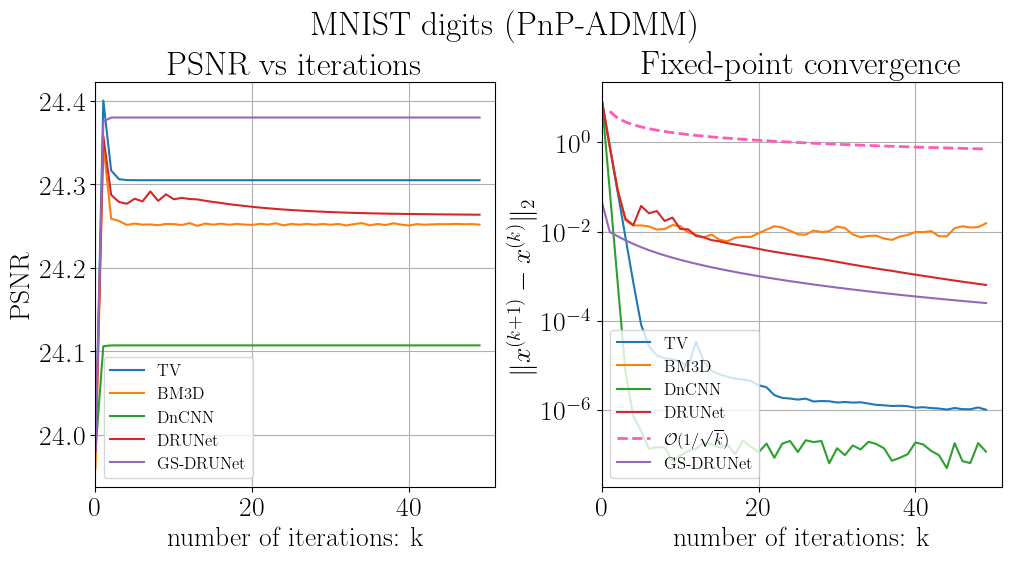

In [1246]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
fig.suptitle('MNIST digits (PnP-ADMM)')
ax1.set_title('PSNR vs iterations')
ax2.set_title('Fixed-point convergence')
def plot_psnrs_differences(psnrs, diffs, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """

    #fig.suptitle(method)
    ax1.plot(range(0, len(psnrs)), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)

    ax2.semilogy(range(0, len(diffs)),diffs, label = method)
    ax2.set_ylabel('$\\|x^{(k+1)} - x^{(k)}\|_2$')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)
    ax1.set_xlim([0, 51])
    ax2.set_xlim([0, 51])
    return psnrs[-1]

#proxpsnr = plot_psnrs_differences(aproxpsnr, aproxincr, 'Prox')
tvpsnr = plot_psnrs_differences(atvpsnr, atvincr, 'TV')
bm3dpsnr = plot_psnrs_differences(abm3dpsnr[:50], abm3dincr[:50], 'BM3D')
dncnnpsnr = plot_psnrs_differences(adncnnpsnr, adncnnincr, 'DnCNN')
drunetpsnr = plot_psnrs_differences(adrunetpsnr, adruincr, 'DRUNet')
iterations = np.arange(50)

#ax2.semilogy(iterations, 80/iterations, label = '$\\mathcal{O}(1/k)$', linestyle = '--', color = '#FF5AB7', linewidth = 2)
ax2.semilogy(iterations, 5/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)
gspsnr = plot_psnrs_differences(gslist, agsincr, 'GS-DRUNet')
apsnrs_list = [21.89, tvpsnr, bm3dpsnr, dncnnpsnr, drunetpsnr, gspsnr]

ax1.legend(fontsize = 12, loc = 'best')
ax2.legend(fontsize = 12, loc = 'best')
plt.savefig('plots/PnPADMMMNISTGraphs.png', dpi = 300)

In [885]:
psnrs_list

[tensor(23.4486),
 tensor(32.7439),
 tensor(17.3241),
 tensor(28.3679),
 tensor(19.0680),
 tensor(20.6090)]

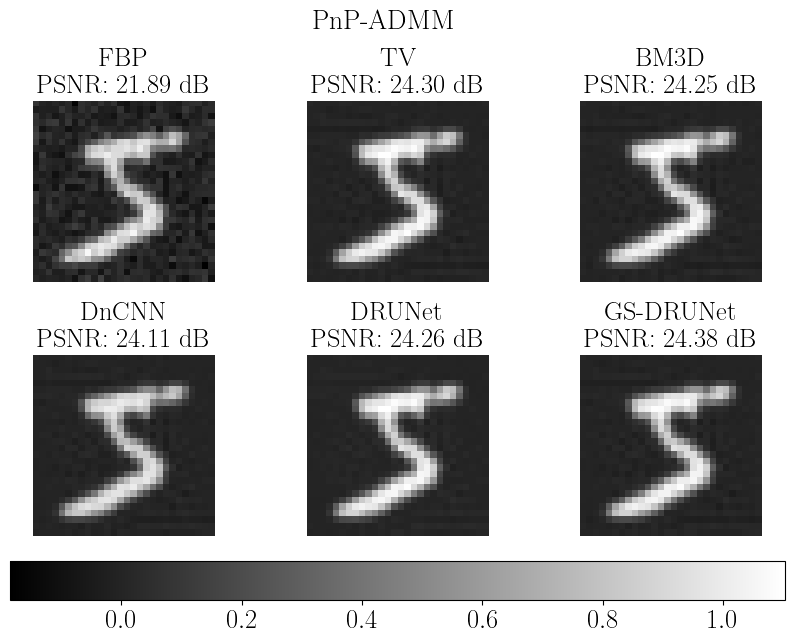

In [1247]:
plotting_estimates1(gfbp.reshape(imsize), admm_tv.reshape(imsize), admm_bm3d.reshape(imsize), admm_dncnn.reshape(imsize), admm_dru.reshape(imsize), admm_gsdru.reshape(imsize), apsnrs_list, title = 'PnP-ADMM')

In [ ]:
display_images([x_prox.reshape(imsize), tv.reshape(imsize), x_d.reshape(imsize), x_dru.reshape(imsize)], ['Proximal','TV', 'DnCNN', 'DRUNet'], x)

# Residual noise distribution
## Figures
- Before - $x^{(k)}$ image
- After - $D(x^{(k)})$ image
- $D(x) - x$ image
- Histogram (pdf) of the individual pixels of $(D(x^{(k)}_i) - x^{(k)}_i)$ (784 items)



In [ ]:
abm3dpairs

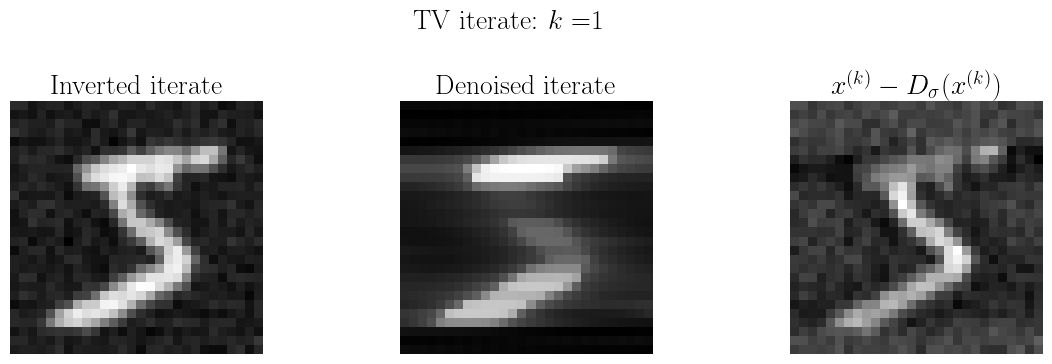

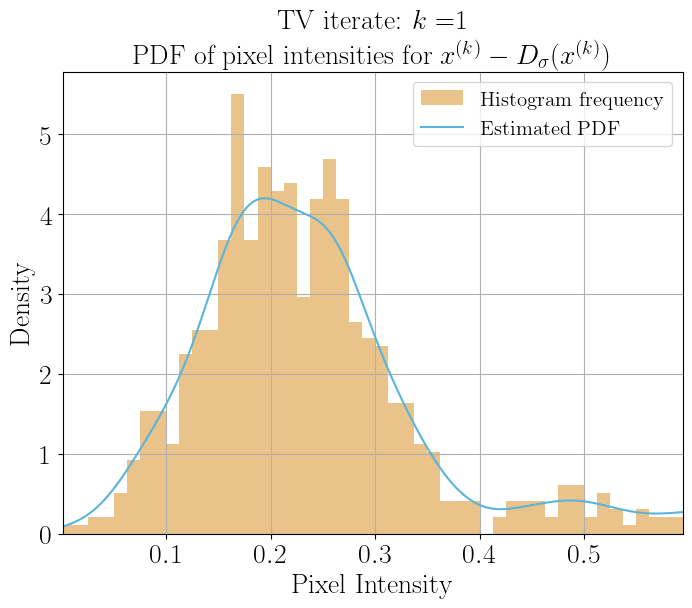

mean=0.2655, standard deviation=0.1630


ValueError: The sample must contain at least two observations.

In [647]:
shift = 0
iterates = [0, 199]

for i in iterates:
    #pdf_plot(aproxdiff[i+shift], aproxpairs, iteration = i+shift, title = "Prox iterate:")
    pdf_plot(atvdiff[i+shift], atvpairs, iteration = i+shift, title = "TV iterate: $k=$")
    #pdf_plot(acnndiff[i+shift], adncnnpairs, iteration = i+shift, title = "DnCNN iterate: $k=$")
    pdf_plot(adrudiff[i+shift], adrupairs, iteration = i+shift, title = "DRUNet iterate: $k=$")
    #pdf_plot(agsdrudiff[i+shift], agsdrupairs, iteration = i+shift, title = "GS-DRUNet iterate: $k=$")
    #pdf_plot(abm3diff[i], abm3dpairs, iteration = i+shift, title = "BM3D iterate: $k=$")